# GA4GH Data Access Example

For this example, metadata have been loaded into a test data registry so they can be accessed using GA4GH methods. `python gdc_dos.py`

## Import the client and models

This will import a Python client and models for accessing data as defined in the schemas.

In [18]:
from ga4gh.dos.client import Client
local_client = Client('http://localhost:8080/')
client = local_client.client
models = local_client.models

## Listing Data Objects

To list the existing Data Objects, we send a ListDataObjectsRequest to the `ListDataObjects` method!

In [19]:
ListDataObjectsRequest = models.get_model('ga4ghListDataObjectsRequest')
list_request = client.ListDataObjects(body=ListDataObjectsRequest(page_size=10000000))
list_response = list_request.result()
print("Number of Data Objects: {} ".format(len(list_response.data_objects)))

Number of Data Objects: 1515 


These Data Object messages are for testing purposes only but should contain enough to retrieve their contents from GDC servers.

In [20]:
data_objects = list_response.data_objects
data_object = data_objects[11]
print('url: {}, file_size (B): {}'.format(data_object.urls[0].url, data_object.size))

url: https://api.gdc.cancer.gov/data/4221fb8c-44e6-4e2a-9207-d8868cfb6ce5, file_size (B): 253864


## Filter Public Data

We want to use this service to eventually download data, but first we must find data we have access to.

In [21]:
public_data_objects = filter(
    lambda x: x['urls'][0]['system_metadata']['access'] == 'open', 
    data_objects)
print('Number of public Data Objects: {}'.format(len(public_data_objects)))

public_data_object = public_data_objects[0]

Number of public Data Objects: 705


## Download a file

We can then download this file and name it.

In [22]:
import requests

# https://stackoverflow.com/questions/16694907/how-to-download-large-file-in-python-with-requests-py
def download_file(url, filename):
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return filename

In [23]:
download_file(public_data_object.urls[0].url, data_object.name)

u'118933b6-86c7-4668-9973-424ece352a60.htseq.counts.gz'

## Verify the checksum

Data Object messages contain checksums of the underlying files. We can validate it here.

In [24]:
print(public_data_object.checksums)

[ga4ghChecksum(checksum=u'17b0e94c31294d25b8788ef3132693e7', type=u'md5')]


In [25]:
given_checksum = public_data_object.checksums[0].checksum

# https://stackoverflow.com/questions/3431825/generating-an-md5-checksum-of-a-file
import hashlib
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

print(md5(data_object.name))
print(given_checksum)
print(given_checksum == md5(data_object.name))

17b0e94c31294d25b8788ef3132693e7
17b0e94c31294d25b8788ef3132693e7
True


## Visualizing the contents of the registry

Here, we look at the file sizes of the contents of the registry. This is a histogram where each bin is a count of the number of files with a size in that range. We plot with a log axis because of the number of very small files dominates a linear scale.

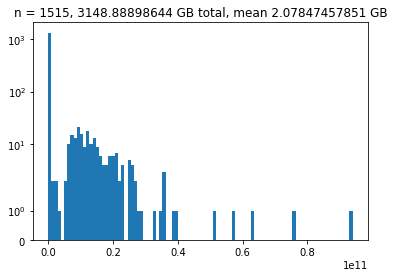

In [26]:
import matplotlib.pyplot as plt
file_sizes = [float(x.size) for x in data_objects]
plt.hist(file_sizes, bins=96)
plt.title("n = {}, {} GB total, mean {} GB".format(len(file_sizes), str(sum(file_sizes) / 1000000000.0), (sum(file_sizes) / len(file_sizes)) / 1000000000.0 ))
plt.yscale('symlog')
plt.show()

Observe that most of the non-tiny files are around 2GB and a few files are very large.

## Make a Data Bundle of some Data Objects

We can now organize some of the Data Objects into a bundle so we can share them together. 

For example, a few publicly available items. First, we have to gather the list of data objects and compute their concatenated hash.

### Calculate the hash for our Objects

In [27]:
public_data_object_ids = [x.id for x in public_data_objects]
print(public_data_object_ids[0])
hashes = [x.checksums[0].checksum for x in public_data_objects]
print(hashes[0])
bundle_md5 = hashlib.md5()
bundle_md5.update(''.join(hashes[0:10]))
bundle_digest = bundle_md5.hexdigest()
print(bundle_digest)

33ff00a8-87fd-4c0a-9bea-8024f5257a81
17b0e94c31294d25b8788ef3132693e7
cf7c1e22b0426059acab93cbe0645547


### Create a new Data Bundle

In [28]:
CreateDataBundleRequest = models.get_model('ga4ghCreateDataBundleRequest')
DataBundle = models.get_model('ga4ghDataBundle')
Checksum = models.get_model('ga4ghChecksum')
my_bundle = DataBundle(
    name="My Bundle",
    checksums=[Checksum(checksum=bundle_digest, type='md5')],
    data_object_ids=public_data_object_ids[0:10],
    aliases=["bundle-alias", "access:public"])
create_request = CreateDataBundleRequest(data_bundle=my_bundle)
create_response = client.CreateDataBundle(body=create_request).result()
print(create_response.data_bundle_id)

10311cb8-0569-4dec-a263-138a0f394643


Let's now verify the Data Bundle appears as expected:

In [29]:
get_bundle_response = client.GetDataBundle(data_bundle_id=create_response.data_bundle_id).result()
print(get_bundle_response.data_bundle.data_object_ids)

[u'33ff00a8-87fd-4c0a-9bea-8024f5257a81', u'38f7de46-0e26-4f7e-bd76-0972cff8175e', u'e2b03c4a-bb71-4afa-ab86-d7243bca84a8', u'e36b3ac1-2d01-436a-88fe-5a88cff14a38', u'da07a798-73e4-4c2e-b1dc-558206750c80', u'9184e71b-fbfd-42f3-bb76-256fbce6c230', u'1e061265-2d0e-4b2d-93f6-fc8736f4178c', u'c1ac87f1-2464-44b4-a7f7-fed5e3dd2214', u'71f94630-e3ab-43ed-8901-49a401dc9f42', u'3ea489d2-7744-47ec-a88e-28f5a76f7355']
